In [34]:
import pandas as pd
import numpy as np
import seaborn as sns
import random
import time
import re

from tqdm import tqdm
from matplotlib import pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import explained_variance_score
from sklearn.metrics import r2_score

from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = [9,5]
plt.rcParams["axes.edgecolor"] = "black"

## Model building (Non NN)

In [20]:
class trainAndEvaluate:
    def __init__(self,df,model):
        self.df = df
        self.model = model
        self.model_name = re.findall(r'(?<=\.)[a-zA-Z]+(?=\')',str(self.model.__class__))[0]
        self.X = self.df[[col for col in self.df.columns if col != 'price']]
        self.y = self.df['price']
        

    def KFold_score(self, n_folds = 10):
        
        print('___________________________________________')
        print(f'{n_folds}-Fold-CV Results for {self.model_name} model.')
        print('___________________________________________')
        
        cv = KFold(n_splits = n_folds,
                   random_state = 1,
                   shuffle = True) 
        
        # RMSE handling for log
        rmse = 'neg_root_mean_squared_error' 
        rmse_test = 'test_neg_root_mean_squared_error' 
        scores = cross_validate(self.model,
                                 self.X,
                                 self.y,
                                 scoring = ['neg_root_mean_squared_error','r2'],
                                 cv = cv,
                                 n_jobs= - 1)
        
        R2 = scores['test_r2'].mean()
        NRMSE = np.abs(scores[rmse_test]).mean()/(self.y.std())
        
        print(f'R^2 = {R2}')
        print(f'NRMSE = {NRMSE}')
    
    def regression_eval_nonn(self,
                             show_results = 1,
                             plot = 1):
        
    
        train_input,test_input,train_output,test_output  = train_test_split(self.X,self.y)
    
        self.model.fit(train_input, train_output)
        y_pred = self.model.predict(test_input)

         # extract line of best fit statistics
        slope, intercept, r_value, p_value, std_err = stats.linregress(test_output,y_pred)

#         MAE = mean_absolute_error(test_output, y_pred)
#         MSE = mean_squared_error(test_output, y_pred, squared = 1)
#         EV = explained_variance_score(test_output, y_pred)
#         RMSE = mean_squared_error(test_output, y_pred, squared = 0)
        
        N_RMSE = (mean_squared_error(test_output, y_pred, squared = 0))/(test_output.std()) 
        
        R2 = r2_score(test_output, y_pred)


        # Extract name from model __class__
        model_name = re.findall(r'(?<=\.)[a-zA-Z]+(?=\')',str(self.model.__class__))[0]

        if show_results:
            print('---------------')
            print(f'{self.model_name} Results: ')
            print('---------------')
#             print(f'MAE = {MAE:.2f} AED.')
#             print(f'MSE = {MSE:.2f} AED.')
#             print(f'RMSE = {RMSE:.2f} AED.')

            print(f'NRMSE = {N_RMSE:.2f} AED.')
            print(f'R^2 score = {R2:.2f}')
#             print(f'EV = {EV:.2f}')
            if plot:
                print('\nRegression Line Metrics: ')
                print('---------------------------')
                print(f'r = {r_value:.2f}, p = {p_value:.2f}, err = {std_err:.2f}')
                # plot A vs. P plot with regression line
                sns.regplot(x = test_output, y = y_pred, line_kws = {'label': f' y = {slope:.1f} x + {intercept:.1f}'})
                plt.legend()
                plt.title(f'{self.model_name}')
                plt.xlabel('Actual Price (AED)')
                plt.ylabel('Predicted Price (AED)')
                plt.show()
        else:
            return ("""model_name,MAE,MSE,RMSE,""",N_RMSE,R2)

## Data

In [21]:
df = pd.read_csv('datasets/training/train_rob_log.csv')

# Target column
y = df['price']

# Feature columns and matrix
features = [col for col in df.columns if col not in ('price')]
X = df[features]

# Create the test train split
train_X, val_X, train_y, val_y = train_test_split(X, y, random_state = 0, test_size = 0.2)

## Baseline Runs

### XGB

In [22]:
trainAndEvaluate(df,XGBRegressor()).KFold_score()

___________________________________________
10-Fold-CV Results for XGBRegressor model.
___________________________________________
R^2 = 0.8252994596445482
NRMSE = 0.4057954689399343


<IPython.core.display.Javascript object>

---------------
XGBRegressor Results: 
---------------
NRMSE = 0.36 AED.
R^2 score = 0.87

Regression Line Metrics: 
---------------------------
r = 0.93, p = 0.00, err = 0.01


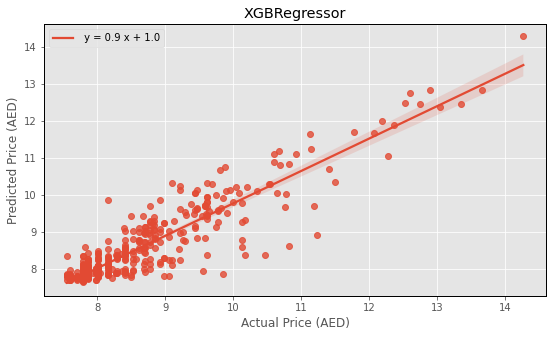

In [28]:
trainAndEvaluate(df,XGBRegressor()).regression_eval_nonn()

### Random forest

In [30]:
trainAndEvaluate(df,RandomForestRegressor()).KFold_score()

___________________________________________
10-Fold-CV Results for RandomForestRegressor model.
___________________________________________
R^2 = 0.8334278638456268
NRMSE = 0.3956638711808592


<IPython.core.display.Javascript object>

---------------
RandomForestRegressor Results: 
---------------
NRMSE = 0.41 AED.
R^2 score = 0.83

Regression Line Metrics: 
---------------------------
r = 0.91, p = 0.00, err = 0.01


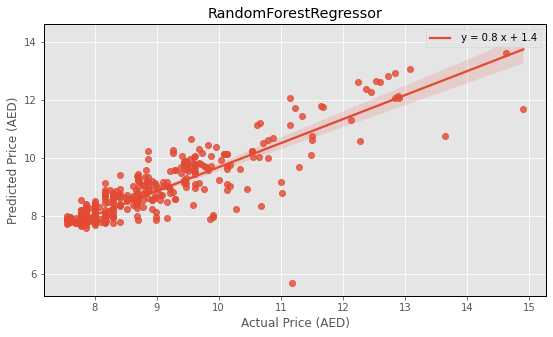

In [29]:
trainAndEvaluate(df,RandomForestRegressor()).regression_eval_nonn()

## Exhaustive Grid Search for hyper parameter tuning

### XGB

In [44]:
# Parameter dictionary for combinations with feasibile values
params = { 'max_depth': np.linspace(3,10,4).astype(int),
           'learning_rate': np.linspace(0.01,1,4),
           'n_estimators': np.linspace(100,1000,4).astype(int),
           'colsample_bytree': np.linspace(0.01,1,4)}


xgb_gs = XGBRegressor()
start = time.time()

clf = GridSearchCV(estimator = xgb_gs, 
                   param_grid = params,
                   scoring = 'neg_root_mean_squared_error', 
                   verbose = 2,
                   n_jobs = -1)
clf.fit(X, y)
end = time.time()

print(f'Total run time - {(end-start)//60} minutes. \n')
print("Best parameters: \n", clf.best_params_)

<IPython.core.display.Javascript object>

Fitting 5 folds for each of 256 candidates, totalling 1280 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    7.0s
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:   15.9s
[Parallel(n_jobs=-1)]: Done 341 tasks      | elapsed:   34.5s
[Parallel(n_jobs=-1)]: Done 624 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 989 tasks      | elapsed:  5.0min
[Parallel(n_jobs=-1)]: Done 1280 out of 1280 | elapsed:  7.9min finished


Total run time - 7.0 minutes. 

Best parameters: 
 {'colsample_bytree': 0.67, 'learning_rate': 0.34, 'max_depth': 3, 'n_estimators': 400}


In [53]:
# Seems the results don't improve on hypter parameter tuning
trainAndEvaluate(df,XGBRegressor(colsample_bytree = 0.67,
                                          learning_rate = 0.34,
                                          max_depth = 3,
                                          n_estimators = 400)).KFold_score()

___________________________________________
10-Fold-CV Results for XGBRegressor model.
___________________________________________
R^2 = 0.8318980047082268
NRMSE = 0.3998822267761517


### Random Forest

In [ ]:
# Parameter dictionary for combinations with feasibile values
params = {'bootstrap': [True],
             'max_depth': np.arange(50,210,10),
             'max_features': np.arange(1,6,1),
             'min_samples_leaf': np.arange(2,11,1),
             'min_samples_split': np.arange(6,14,2),
             'n_estimators': np.arange(100,1100,200)}


rf = RandomForestRegressor()
start = time.time()

clf = GridSearchCV(estimator = rf, 
                   param_grid = params,
                   scoring = 'neg_root_mean_squared_error', 
                   verbose = 2,
                   n_jobs = -1)
clf.fit(X, y)
end = time.time()

print(f'Total run time - {(end-start)//60} minutes. \n')
print("Best parameters: \n", clf.best_params_)

Fitting 5 folds for each of 14400 candidates, totalling 72000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    5.7s
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:   25.2s
[Parallel(n_jobs=-1)]: Done 341 tasks      | elapsed:   54.3s
[Parallel(n_jobs=-1)]: Done 624 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 989 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 1434 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done 1961 tasks      | elapsed:  4.9min
[Parallel(n_jobs=-1)]: Done 2568 tasks      | elapsed:  6.7min
[Parallel(n_jobs=-1)]: Done 3257 tasks      | elapsed:  9.0min
[Parallel(n_jobs=-1)]: Done 4026 tasks      | elapsed: 11.6min
[Parallel(n_jobs=-1)]: Done 4877 tasks      | elapsed: 14.1min
[Parallel(n_jobs=-1)]: Done 5808 tasks      | elapsed: 16.3min
[Parallel(n_jobs=-1)]: Done 6821 tasks      | elapsed: 19.0min
[Parallel(n_jobs=-1)]: Done 7914 tasks      | elapsed: 22.3min
[Parallel(n_jobs=-1)]: Done 9089 tasks      | 